## Import modules

In [1]:
import xarray as xr
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
import scipy.stats as sc
import metpy as mtp
import math
from scipy import integrate
import ERA5_functions as era_fncts
import pandas as pd

from matplotlib.pyplot import cm
import datetime as dt

import cartopy.crs as ccrs
from numpy.random import default_rng

%load_ext autoreload
%autoreload 2

### Constants

In [2]:
a=6371220 #radius of earth in m
L=2.5E6 #Latent heat in atmosphere
L_ice=3.34e5 #Latent heat of fusion
g=9.81 #Acceleration from gravity
conv_pw=1e15 #Conversion from watts to PW
cp=1007          
    

### Dimensions/coordinates

In [3]:
lats = np.linspace(90, -90, 361)
lons = np.linspace(0, 359.5, 720)
levels = [1, 2, 3, 5, 7, 10, 20, 30, 50, 70, 100, 125, 150, 175, 200, 225, 250, 300, 350,
            400, 450, 500, 550, 600, 650, 700, 750, 775, 800, 825, 850, 875, 900, 925, 950, 975, 1000]
geometry = 2 * np.pi * np.cos(np.deg2rad(np.asarray(lats))) * a / g

### Load instantaneous AHT calcs

In [4]:
ddir = 'aht_time_series/'
eddy_files = sorted(glob(ddir + 'eddy*'))
mmc_files = sorted(glob(ddir + 'mmc*'))

eddy_moist_files = sorted(glob(ddir + 'moist_aht/eddy_moist_all_times*'))
mmc_moist_files = sorted(glob(ddir + 'moist_aht/mmc_moist_all_times*'))

In [5]:
eddy_moist_data = []
for eddy in eddy_moist_files:
    file_data = np.load(eddy)
    eddy_moist_data.append(file_data)

eddy_all_times_moist = np.concatenate(eddy_moist_data)
        
mmc_moist_data = []
for mmc in mmc_moist_files:
    file_data = np.load(mmc)
    mmc_moist_data.append(file_data)

mmc_all_times_moist = np.concatenate(mmc_moist_data)
        
eddy_data = []
for eddy in eddy_files:
    file_data = np.load(eddy)
    eddy_data.append(file_data)

eddy_all_times = np.concatenate(eddy_data)
        
mmc_data = []
for mmc in mmc_files:
    file_data = np.load(mmc)
    mmc_data.append(file_data)

mmc_all_times = np.concatenate(mmc_data)

### Remove seasons

In [6]:
mmc_all_times_no_season = np.zeros_like(mmc_all_times)

eddy_all_times_no_season = np.zeros_like(eddy_all_times)

for lat_idx in range(361): #Loop through each latitude
    mmc_all_times_no_season[:,lat_idx] = era_fncts.remove_seasons_spline(
        mmc_all_times[:,lat_idx], num_knots=6)[0]
    eddy_all_times_no_season[:,lat_idx] = era_fncts.remove_seasons_spline(
        eddy_all_times[:,lat_idx], num_knots=6)[0]

mmc_all_times_no_season_moist = np.zeros_like(mmc_all_times_moist)

eddy_all_times_no_season_moist = np.zeros_like(eddy_all_times_moist)

for lat_idx in range(361): #Loop through each latitude
    mmc_all_times_no_season_moist[:,lat_idx] = era_fncts.remove_seasons_spline(
        mmc_all_times_moist[:,lat_idx], num_knots=6)[0]
    eddy_all_times_no_season_moist[:,lat_idx] = era_fncts.remove_seasons_spline(
        eddy_all_times_moist[:,lat_idx], num_knots=6)[0]

In [7]:
total_all_times = eddy_all_times + mmc_all_times
total_all_times_no_season = eddy_all_times_no_season + mmc_all_times_no_season

total_all_times_moist = eddy_all_times_moist + mmc_all_times_moist
total_all_times_no_season_moist = eddy_all_times_no_season_moist + mmc_all_times_no_season_moist

total_all_times_dry = total_all_times - total_all_times_moist
total_all_times_no_season_dry = total_all_times_no_season - total_all_times_no_season_moist

eddy_all_times_dry = eddy_all_times - eddy_all_times_moist
eddy_all_times_no_season_dry = eddy_all_times_no_season - eddy_all_times_no_season_moist

mmc_all_times_dry = mmc_all_times - mmc_all_times_moist
mmc_all_times_no_season_dry = mmc_all_times_no_season - mmc_all_times_no_season_moist

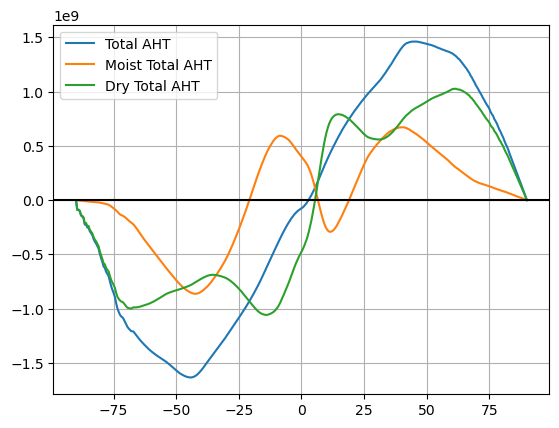

In [13]:
plt.plot(lats, np.mean(total_all_times, axis=0), label='Total AHT')
plt.plot(lats, np.mean(total_all_times_moist, axis=0), label='Moist Total AHT')
plt.plot(lats, np.mean(total_all_times_dry, axis=0), label='Dry Total AHT')

plt.legend(loc=0)
plt.axhline(0, color='k')
plt.grid()
plt.show()

In [15]:
time_range = pd.date_range('1979-01-01', '2018-12-31 18:00:00', freq='6H')

final_ds = xr.Dataset(
                        data_vars = dict(
                            total_aht=(['time', 'latitude'], total_all_times),
                            eddy_aht=(['time', 'latitude'], eddy_all_times),
                            mmc_aht=(['time', 'latitude'], mmc_all_times),
                            total_aht_no_seasons=(['time', 'latitude'], total_all_times_no_season),
                            eddy_aht_no_seasons=(['time', 'latitude'], eddy_all_times_no_season),
                            mmc_aht_no_seasons=(['time', 'latitude'], mmc_all_times_no_season),
                            total_aht_moist=(['time', 'latitude'], total_all_times_moist),
                            eddy_aht_moist=(['time', 'latitude'], eddy_all_times_moist),
                            mmc_aht_moist=(['time', 'latitude'], mmc_all_times_moist),
                            total_aht_no_seasons_moist=(['time', 'latitude'], total_all_times_no_season_moist),
                            eddy_aht_no_seasons_moist=(['time', 'latitude'], eddy_all_times_no_season_moist),
                            mmc_aht_no_seasons_moist=(['time', 'latitude'], mmc_all_times_no_season_moist),
                            total_aht_dry=(['time', 'latitude'], total_all_times_dry),
                            eddy_aht_dry=(['time', 'latitude'], eddy_all_times_dry),
                            mmc_aht_dry=(['time', 'latitude'], mmc_all_times_dry),
                            total_aht_no_seasons_dry=(['time', 'latitude'], total_all_times_no_season_dry),
                            eddy_aht_no_seasons_dry=(['time', 'latitude'], eddy_all_times_no_season_dry),
                            mmc_aht_no_seasons_dry=(['time', 'latitude'], mmc_all_times_no_season_dry),
                        ),
                        coords=dict(
                            time=time_range,
                            latitude=lats)
    )
    
#final_ds.to_netcdf('aht_time_series/era5_aht_time_series.nc', mode='w')

### Make one with monthly time resolution

In [16]:
aht_ds_monthly = final_ds.resample(time="1M").mean(['time'])

In [17]:
#aht_ds_monthly.to_netcdf('aht_time_series/era5_monthly_aht_time_series.nc', mode='w')